# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
train_df = pd.read_csv("./data/Bikeshare_train.csv")
test_df  = pd.read_csv("./data/Bikeshare_test.csv")

In [3]:
train_df.head()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [4]:
#  Remove the 'Unnamed: 0' column, which is merely a copy of the row index number
train_df = train_df.drop('Unnamed: 0', 1)
test_df = test_df.drop('Unnamed: 0', 1)

In [5]:
# Look at feature statistics and comparisons

from scipy.stats import ttest_ind

#Get statistics and pvalues for rental count by season
print("SEASON VS RENTAL COUNT STATISTICS\n")
season_counts = train_df.groupby(['season'])['count']
print(season_counts.describe())
#print(season_counts.groups.keys())

#Create a dataframe of pvalues for each of the season combinations
print("\nT Test PValues:")
pValMatrix = []
seasonLabels = [1.0, 2.0, 3.0, 4.0]
for i in range(0, 4):
    row = []
    for j in range(0, 4):
        #Some redundancy left in for the readability of the code, but this calculation is fast
        pval = ttest_ind(season_counts.get_group(seasonLabels[i]).values, season_counts.get_group(seasonLabels[j]).values).pvalue
        row.append(pval)
    pValMatrix.append(row)

season_pval_df = pd.DataFrame(pValMatrix)
print(season_pval_df.head())

#Get statistics and pvalue for rental count by holiday status
print("\nHOLIDAY VS RENTAL COUNT STATISTICS\n")
holiday_counts = train_df.groupby(['holiday'])['count']
print(holiday_counts.describe())
print("\n")
print("\nT Test PValue:")
print(ttest_ind(holiday_counts.get_group(0.0).values, holiday_counts.get_group(1.0).values).pvalue)


#Get statistics and pvalue for rental count by working day status
print("\nWORKING VS RENTAL COUNT DAY STATISTICS\n")
workingday_counts = train_df.groupby(['workingday'])['count']
print(workingday_counts.describe())
print("\nT Test PValue")
print(ttest_ind(workingday_counts.get_group(0.0).values, workingday_counts.get_group(1.0).values).pvalue)
print("\n")

#Get statistics and pvalue for rental count by weather
print("\nWEATHER VS RENTAL COUNT STATISTICS\n")
weather_counts = train_df.groupby(['weather'])['count']
print(weather_counts.describe())
print("\nT Test PValues")
weatherLabels = [1.0, 2.0, 3.0]
pValMatrix = []
for i in range(0, 3):
    row = []
    for j in range(0, 3):
        pval = ttest_ind(weather_counts.get_group(weatherLabels[i]).values, weather_counts.get_group(weatherLabels[j]).values).pvalue
        row.append(pval)
    pValMatrix.append(row)
weather_pval_df = pd.DataFrame(pValMatrix)
print(weather_pval_df.head())


SEASON VS RENTAL COUNT STATISTICS

        count         mean          std     min      25%     50%      75%  \
season                                                                      
1.0      72.0  2639.722222  1468.925345   431.0  1491.00  2222.5  3853.75   
2.0      86.0  4985.744186  1682.800825   795.0  4045.25  4937.0  6290.25   
3.0      88.0  5680.738636  1495.718007  1115.0  4567.25  5404.0  7106.75   
4.0      85.0  4745.258824  1736.914445   705.0  3649.00  4748.0  5668.00   

           max  
season          
1.0     6312.0  
2.0     8120.0  
3.0     8714.0  
4.0     8156.0  

T Test PValues:
              0             1             2             3
0  1.000000e+00  1.707907e-16  1.855144e-26  1.386053e-13
1  1.707907e-16  1.000000e+00  4.468631e-03  3.591183e-01
2  1.855144e-26  4.468631e-03  1.000000e+00  2.008431e-04
3  1.386053e-13  3.591183e-01  2.008431e-04  1.000000e+00

HOLIDAY VS RENTAL COUNT STATISTICS

         count         mean          std     min     25%


SCATTER PLOTS



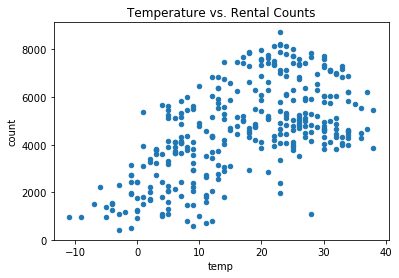

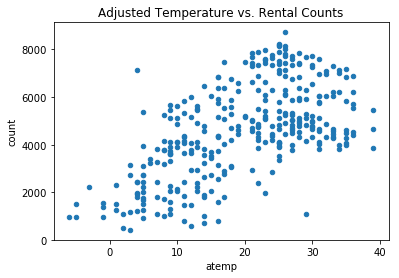

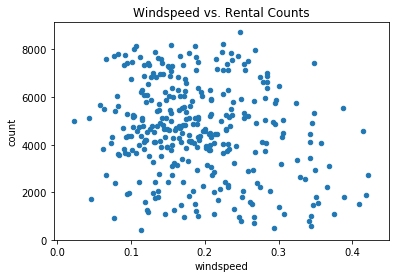

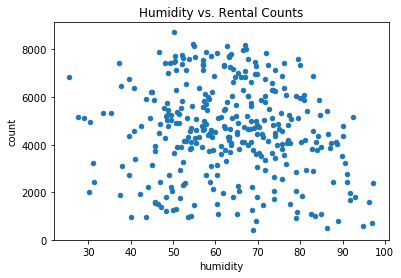

In [6]:
print("\nSCATTER PLOTS\n")

train_df.plot(kind='scatter', x='temp', y='count').set_title("Temperature vs. Rental Counts")

train_df.plot(kind='scatter', x='atemp', y='count').set_title("Adjusted Temperature vs. Rental Counts")

train_df.plot(kind='scatter', x='windspeed', y='count').set_title("Windspeed vs. Rental Counts")

train_df.plot(kind='scatter', x='humidity', y='count').set_title("Humidity vs. Rental Counts")


#### Q. How does the number of bike rentals vary between weekdays and weekends?
On average, there are slightly fewer bike rentals on working days than on weekends, however the two sided t test shows that this difference may not be meaningful.

#### Q. How about bike rentals on holidays?
On average, there are slightly fewer bike rentals on holidays than on non-holidays, although there are only 11 holiday days with data, and the two sided t test shows that this difference may not be meaningful. 

#### Q. What effect does the season have on the bike rentals on a given day?
There are far fewer bike rentals in the Winter, and more bike rentals in the Summer. Spring and Fall have nearly equal numbers of bike rentals on average, with more rentals occurring in the Spring. The double sided t test shows that the bike rental differences between Fall and Spring may not be statistically significant, while the differences between spring/fall, summer, and winter are very significant.

#### Q. Is the number of bike rentals lower than average when there is rain or snow?
Yes, there are fewer bike rentals when it is snowing than when it is raining, and fewer when it is raining than when the weather is good. The double sided t test shows that these differences are significant.

#### Q. How does temperature effect bike rentals?
From the scatter plot, it appears that bike rentals increase with the temperature, but do decrease again as the temperature rises above 24 degrees. 

#### Q. Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?
The adjusted temperature has a similar relationship to the bike rentals as the temperature, which is to be expected. Both humidity and windspeed do not appear to have a strong relationship to the number of bike rentals, although humidity may have a loose relationship. The number of bike rentals appears to drop off when the humidity gets above 80-85%. 


We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [7]:
#  Create dummy variables for the following categorical variables with more than two categories:
#      ['season', 'month', 'day_of_week', 'weather']
#

train_df = pd.get_dummies(train_df, columns = ['season', 'month', 'day_of_week', 'weather'])
test_df = pd.get_dummies(test_df, columns   = ['season', 'month', 'day_of_week', 'weather'])
train_df.head()

# Note:  I'm not dropping the redundant dummy variables now except during model fitting and predicting 
# since wanted to include the redundant variable sin correlation heatmap later
#
#  One dummy variable can be deleted from each categorical set of dummy variables created since they're redundant.
#  Delete the last dummy variable from each newly created categorical set of dummy variables.

def dump_redundant():
    redundant_cols = ['season_3.0', 'month_12.0', 'day_of_week_6.0']
    for redundant_col in redundant_cols:
        train_df.drop(redundant_col, 1)
        test_df.drop(redundant_col, 1)
dump_redundant()


In [8]:
#  As a best practice, normalize the following continuous predictors:
#       ['temp', 'atemp', 'humidity', 'windspeed'] 
#
#  Accomplish this by subtracting on the mean and dividing by the standard deviation 
#  derived from the train set data _ONLY_ for the corresponding predictor.


# Rescale test data using mean and std computed from train data
for predictor in ['temp', 'atemp', 'humidity', 'windspeed']:
    test_df[predictor + "_norm"] = test_df[predictor].transform(lambda x, m = train_df[predictor].mean(), 
                                                                          s = train_df[predictor].std()
                                                                          : (x - m)/s )

# Rescale train data using mean and std computed from train
train_df[['temp_norm', 'atemp_norm', 'humidity_norm', 'windspeed_norm']] = \
          train_df[['temp', 'atemp', 'humidity', 'windspeed']].transform(lambda x: (x - x.mean()) / x.std())

#### Provide a table of the summary statistics of the new attributes (on the train set)

In [9]:
# Summary of the train set normalized continuous varaiables. As expected, they all have mean ~= 0 and std = 1.
train_df[['temp_norm', 'atemp_norm', 'humidity_norm', 'windspeed_norm']].describe()

,temp_norm,atemp_norm,humidity_norm,windspeed_norm
count,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00
25%,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01
50%,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01
75%,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01
max,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00


In [10]:
# Summary of the train 
train_df[['weather_1.0', 'weather_2.0', 'day_of_week_0.0', 'day_of_week_1.0', 
          'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0', 'day_of_week_5.0']].describe()

,weather_1.0,weather_2.0,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.640483,0.329305,0.160121,0.175227,0.135952,0.123867,0.123867,0.145015
std,0.480585,0.470672,0.367273,0.380736,0.343256,0.329929,0.329929,0.352649
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Q:  Why can't they be directly used as predictors? 

A:  Linear regression models are created using quantitative variables, which are measured on a numeric scale.  The Categorical attributes don't have quantitative meaning.  For example, the categorical attribute, month, has a range of a values {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0. 11.0, 12.0} but we can't assume month 12.0 is greater than month 1.0 since those assignments don't have a numerical meaning in a quantitative sense.

#### Q: Why is it okay to not have a binary column for the Kj-th category? 

A:  The Kj-th category is redundant in that setting the Kj-th category column to "1" is equivalent to setting all other columns to zero.

#### Why shouldn't we include the test set observations in computing the mean and SD?

A. Because this would introduce information from the validation set into the training dataset. We need to keep the training dataset free any from influence from the test dataset.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


#### Fit a multiple linear regression model to the training set, and report its R2 score on the test set. 

A:  We obtained a $R^2$ score of 0.249 on the test set.


R2 Score
0.249342111465


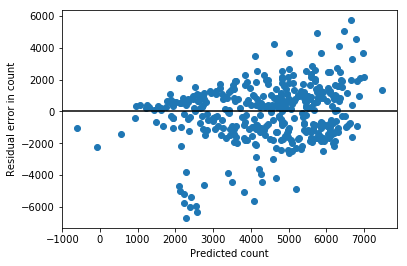


ALL PREDICTORS WITH POSITIVE COEFFICIENTS

          predictor       coef  std err      t  P>|t|    [0.025    0.975]
28      weather_1.0  2628.0414  614.079  4.280  0.000  1420.540  3835.543
29      weather_2.0  2274.4909  585.840  3.882  0.000  1122.518  3426.464
25       season_4.0   907.4368  645.974  1.405  0.161  -362.782  2177.655
24       season_2.0   799.1232  545.448  1.465  0.144  -273.424  1871.671
9           holiday   667.0376  510.806  1.306  0.192  -337.391  1671.466
8   day_of_week_5.0   501.3012  235.333  2.130  0.034    38.551   964.051
7   day_of_week_4.0   438.8470  230.240  1.906  0.057   -13.887   891.581
26             temp   205.0067   96.277  2.129  0.034    15.692   394.322
22        month_9.0   157.4649  710.804  0.222  0.825 -1240.233  1555.163
13       month_10.0   153.6132  493.640  0.311  0.756  -817.061  1124.288
0             const    87.5594   43.633  2.007  0.046     1.761   173.358
10         humidity    12.6803   10.908  1.163  0.246    -8.768    3

In [11]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
#  Create the linear regression model
#
#  Remove the unnormalized continous data columns and the response variable for the train set to 
#  be used with the linear regression model

numeric_cols = ['temp', 'atemp', 'humidity', 'windspeed']
remove_cols = ['count', 'season_3.0', 'month_12.0', 'day_of_week_6.0', 'weather_3.0']

Xtrain = train_df[train_df.columns.difference(remove_cols)]
Xtest  = test_df[test_df.columns.difference(remove_cols)]


#  Create response 
ytrain = train_df['count']
ytest  = test_df['count']

est = LinearRegression()

#  Fit the LR model 
est.fit(Xtrain, ytrain)

#  Predict
ytest_pred = est.predict(Xtest)

# Get R2 score
r2_score_test = r2_score(ytest, ytest_pred)
print("\nR2 Score")
print (r2_score_test)

# Plot residuals by their original predictions
residuals = ytest_pred - ytest
residuals_df = pd.DataFrame()
residuals_df['predictions'], residuals_df['residuals'] = [ytest_pred, residuals]

plt.ylabel("Residual error in count")
plt.xlabel("Predicted count")
plt.scatter(residuals_df['predictions'], residuals_df['residuals'])
plt.axhline(0, color = 'black')
plt.show()

params = np.append(est.intercept_, est.coef_)

# Create an OLS estimate and get summary for analysis
predictors = list(Xtest.keys())
Xtest_intercept = sm.add_constant(Xtest)
ols = sm.OLS(ytest, Xtest_intercept).fit()

# Statsmodel simple table is less than ideal to use -- construct dataframe
summary_data = ols.summary().tables[1].data
header = summary_data.pop(0)
header[0] = 'predictor'

# We get the data as strings -- convert here. 
for i in range(len(summary_data)):
    summary_data[i][1] = float(summary_data[i][1])
    summary_data[i][2] = float(summary_data[i][2])
    summary_data[i][3] = float(summary_data[i][3])
    summary_data[i][4] = float(summary_data[i][4])
    summary_data[i][5] = float(summary_data[i][5])
    summary_data[i][6] = float(summary_data[i][6])

    
summary_df = pd.DataFrame(summary_data, columns=header)

#Get positive coefficients
summary_df.sort_values(by=['coef'], ascending=False, inplace=True)
print("\nALL PREDICTORS WITH POSITIVE COEFFICIENTS\n")
print(summary_df.head(12))

print("\nALL PREDICTORS BY P VAL\n")
summary_df.sort_values(by='P>|t|', inplace=True)
print(summary_df.head(len(summary_df)))



#### Q: Does the residual plot reveal a non-linear relationship between the predictors and response?  

A:  The residual plot above shows the residuals are not distributed around the y-axis in a random symetric fashion, which is what we'd expect for linear relationship.   The residual plot doesn't suggest a non-linear relationship as much as it suggests there _might_ be two separate linear relationships.  Creating a new binary variable, Weekend, might remedy this issue if we think there are different riding patterns based on weekdys vs weekends and we use that as a predictor instead of day_of_week.  This would be worth exploring further. 

#### Q: What does the plot convey about the variance of the error terms? 

A:  The variance is unequal across the range of Count values and the general trend is that the variance increases as the Count increases starting at around Count 1000. This trend is formally known as Heteroscedasticity.  This means that the higher the Count value, the less likely we are to trust the estimate.

#### Q: Which among the predictors have a positive correlation with the number of bike rentals?

Weather_1.0, Weather_2.0, Season_4.0, and Season_2.0 have very large (>799) positive correlations with the number of bike rentals. However the t test only shows a significance level of > 5% for Weather_1.0 and Weather_2.0 

day_of_week_5.0 and temp also have positive coefficients with significance level of < 5%. 

#### Q: Does the day of a week have a relationship with bike rentals?
day_of_week_5.0 is the only day of week that impacts bike rentals with a significance level of < 5%. In general, the days of the week do not appear to be significant predictors. 

#### Q: Does the month influence the bike rentals?
Months also appear near the bottom of the significant predictors list. No months impact bike rentals with a significance level of < 5%

#### Q: What effect does a holiday have on bike rentals?

Holidays appear to have a positive impact on bike rentals, however at a low significance level of 19.2%. 

#### Q: Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.

Yes, the temp coefficient is 194.7484 and the atemp coefficient is -136.1275. While they are over 300 apart, this is not overly surprising given that the range of coefficients is so large. The coefficients ranged from approximately 2600 to -2600, so, all things considered, these two coefficients are fairly close together. In addition, only the p value for temp is significant, so some difference, or even some counter-intuitive results are to be expected. It would be unreasonable to read too much into coefficients this close to zero with such relatively large p values. 

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [12]:
import seaborn as sns

#  Note, I decided to "reinclude" the redundant one-hot encoded dummy variable.  We may want to change that.
#
remove_cols2 = ['count', 'temp', 'atemp', 'humidity', 'windspeed']
Xtrain2 = train_df[train_df.columns.difference(remove_cols2)]
#
#  We use Pandas' 'corr' method to compute pairwise correlation of column (defaults to Pearson)
#  Use Xtrain which omits the unnormalized continuous predictors and the response variable
corr = Xtrain2.corr()
#
#   Should we site the source for the style of this heatmap used below?
#   https://stackoverflow.com/questions/39409866/correlation-heatmap
#
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

####  Q:  Does the data suffer from multi-collinearity?
A:  From examining the correlation heatmap above, the following predictors exhibit collinearity, defined as pairwise correlation approaching (+/- 1):
- temp_norm and atemp_norm pairwise correlation = 0.98, IOW,  almost perfect positive correlation.  This is not surprising since they are both temperature based (one is temperature and the other is apparent outdoor temperature). 
- weather_1.0 (Clear, Few clouds, Partly cloudy, Partly cloudy) and weather_2 (Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist) have pairwise correlation = -0.94, IOW,  almost perfect negative correlation.  This seems a little puzzling!
- Working days, holidays, and days of week have strong correlations, although this is expected. Holidays often fall on Mondays (MLK day, Labor Day, Memorial Day, Columbus Day) and, of course, weekends are not working days. Similar correlations are seen between months and seasons.
- There is a somewhat strong negative correlation (-0.24) between windspeed and humidity

#### Q: Are there predictors that fall into natural groups based on the correlation values? 
The days of week one hot encoded predictor variables fall into  anatural group in that they are all evenly negatively correlated with each other (-0.15 through -0.18).

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




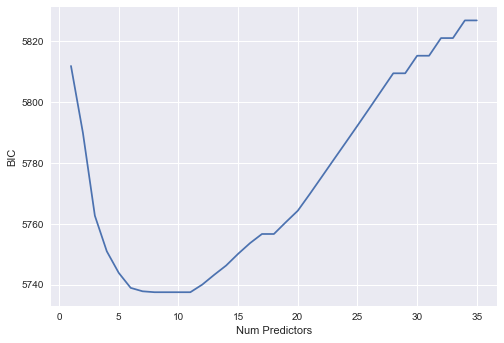

Best Model:
Predictors: ['atemp_norm', 'humidity_norm', 'season_1.0', 'weather_3.0', 'month_9.0', 'month_10.0', 'windspeed']
Number of predictors: 7
BIC: 5737.79879752


In [13]:
def get_bic(Xtrain, ytrain):
    '''
    Used for both step-wise forward and step-wise backward, returns the BIC based on
    an ordinary least squares for the test and train data
    '''
    Xtrain = sm.add_constant(Xtrain)
    model = sm.OLS(ytrain, Xtrain).fit()
    return model.bic

# Using this column for the y data
remove_cols = ['count']

Xtrain = train_df[train_df.columns.difference(remove_cols)]
Xtest  = test_df[test_df.columns.difference(remove_cols)]

ytrain = train_df['count']
ytest  = test_df['count']

# Get a list of all of the available predictors
all_predictors = list(Xtrain.keys())

# Starting with no predictors
predictors = [([], None)]

for k in range(1, len(all_predictors)):
    best_k_minus_1 = predictors[-1][0]
    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    bics = []
    # Iterate through all of the predictors that are not in the current "best set"
    for predictor in new_predictors:
        k_predictors = best_k_minus_1 + [predictor]
        bic = get_bic(Xtrain[k_predictors], ytrain)
        bics.append(bic)
    # Add the predictor that had the best associated BIC
    best_k = best_k_minus_1 + [new_predictors[np.argmin(bics)]]
    predictors.append((best_k, np.min(bics)))

#Plot BIC by number of predictors
bics = [predictor[1] for predictor in predictors]
plt.plot(bics)
plt.ylabel("BIC")
plt.xlabel("Num Predictors")
plt.show()

print("Best Model:")
# Ignore None value
bestIndex = np.argmin(bics[1:])
print("Predictors: "+str(predictors[bestIndex][0]))
print("Number of predictors: "+str(len(predictors[bestIndex][0])))
print("BIC: "+str(predictors[bestIndex][1]))

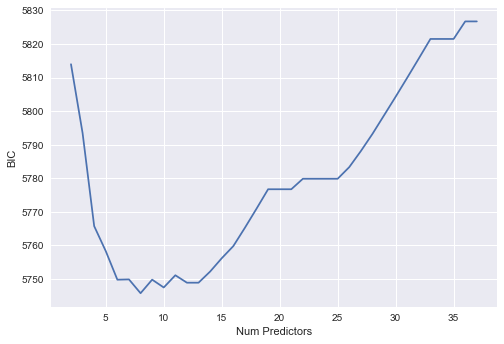

Best Model:
Predictors: ['season_4.0', 'temp_norm', 'month_7.0', 'month_6.0', 'month_8.0', 'season_2.0', 'humidity', 'windspeed_norm']
Number of predictors: 8
BIC: 5749.81360495


In [14]:
all_predictors = list(Xtrain.keys())

# Begin with a list of all predictors
predictors = [(all_predictors, get_bic(Xtrain, ytrain))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    bics = []
    # Iterate through the predictors in the "best predictors" list to 
    # decide which one to remove
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        Xtrain_tmp = Xtrain[k_minus_1].values
        bics.append(get_bic(Xtrain_tmp, ytrain))
    # Remove the predictor with the worst BIC
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(bics)]]))
    predictors.append((best_k_minus_1, np.min(bics)))


# Plot BIC by number of predictors
bics = [predictor[1] for predictor in predictors]    
num_predictors = list(range(len(bics)+1, 1, -1))
plt.plot(num_predictors, bics)
plt.ylabel("BIC")
plt.xlabel("Num Predictors")
plt.show()

# Print stats about the best model found
print("Best Model:")
# Ignore None value
bestIndex = np.argmin(bics[1:])
print("Predictors: "+str(predictors[bestIndex][0]))
print("Number of predictors: "+str(len(predictors[bestIndex][0])))
print("BIC: "+str(predictors[bestIndex][1]))


####  We implemented Step-wise forward selection from scratch and selected the model with the lowest Bayesian Information Criterion (BIC) and it selected the following predictors:  ['atemp_norm', 'humidity_norm', 'season_1.0', 'month_9.0', 'month_10.0', 'windspeed_norm', 'month_7.0']  

#### Q:  Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? 

A: Yes, atemp_norm and temp_norm are are collinear and  temp_norm was excluded.  Weather_1.0 and weather_2.0 were collinear but both were eliminated, *possibly* since they were introduced later in our step-wise forward selection algorithm. 

#### Q: How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?  

A:  The test $R^2$ from Part (b) is higher (better) than the Step-wise forward selection model test $R^2$, 0.249 and 0.234, respectively.  We note that the BIC metric is typically employed when a simpler model is desired while $R^2$ is used if predictive power is desired.

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [15]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

def get_r2_with_predictors(X_train, y_train, X_test, y_test, predictors):
    '''
        Get the r2
    '''
    X_train = X_train[predictors]
    X_test = X_test[predictors]
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    predictions = lin.predict(X_test)
    return r2_score(y_test, predictions)

def get_forward_r2(Xtrain, ytrain, Xtest, ytest):
    predictors = ['atemp', 'humidity', 'season_1.0', 'weather_3.0', 'month_9.0', 'month_10.0', 'windspeed']
    return get_r2_with_predictors(Xtrain, ytrain, Xtest, ytest, predictors)

def get_backward_r2(Xtrain, ytrain, Xtest, ytest):
    predictors = ['windspeed_norm', 'weather_3.0', 'temp', 'month_9.0', 'month_5.0', 'humidity_norm', 'month_4.0', 'month_10.0', 'month_11.0', 'temp_norm', 'weather_1.0']
    return get_r2_with_predictors(Xtrain, ytrain, Xtest, ytest, predictors)

def get_all_preds_r2(Xtrain, ytrain, Xtest, ytest):
    predictors = ['atemp', 'atemp_norm', 'day_of_week_0.0', 'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0', 'day_of_week_5.0', 'day_of_week_6.0', 'holiday', 'humidity', 'humidity_norm', 'month_1.0', 'month_10.0', 'month_11.0', 'month_12.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0', 'temp', 'temp_norm', 'weather_1.0', 'weather_2.0', 'weather_3.0', 'windspeed', 'windspeed_norm', 'workingday']
    return get_r2_with_predictors(Xtrain, ytrain, Xtest, ytest, predictors)

remove_cols = ['count']

Xtrain = train_df[train_df.columns.difference(remove_cols)]
Xtest  = test_df[test_df.columns.difference(remove_cols)]
# Train on train data, get R2 for test for each of the three models
# using 10-fold validation

ytrain = train_df['count']
ytest  = test_df['count']
kf = KFold(n_splits=10)

r2s = {'forward': [], 'backward': [], 'all': []}
for test_train_idx in kf.split(train_df):
    Xtrain_tmp = Xtrain.iloc[test_train_idx[0]]
    Xtest_tmp = Xtrain.iloc[test_train_idx[1]]
    ytrain_tmp = ytrain.iloc[test_train_idx[0]]
    ytest_tmp = ytrain.iloc[test_train_idx[1]]

    r2s['forward'].append(get_forward_r2(Xtrain_tmp, ytrain_tmp, Xtest_tmp, ytest_tmp))
    r2s['backward'].append(get_backward_r2(Xtrain_tmp, ytrain_tmp, Xtest_tmp, ytest_tmp))
    r2s['all'].append(get_all_preds_r2(Xtrain_tmp, ytrain_tmp, Xtest_tmp, ytest_tmp))

# Get stats for collected forward/backward/all R2 scores
r2s_df = pd.DataFrame()
r2s_df['forward'],r2s_df['backward'],r2s_df['all'] = [r2s['forward'], r2s['backward'], r2s['all']]

print(r2s_df.describe())
    
# Fit on test data and get R2s for test data predictions
print("\nR2s on Test Data:\n")
print("Forward: "+str(get_forward_r2(Xtest, ytest, Xtest, ytest)))
print("Backward: "+str(get_backward_r2(Xtest, ytest, Xtest, ytest)))
print("All: "+str(get_all_preds_r2(Xtest, ytest, Xtest, ytest)))



    

         forward   backward        all
count  10.000000  10.000000  10.000000
mean    0.445167   0.448770   0.342580
std     0.165430   0.156791   0.258495
min     0.157165   0.182119  -0.209477
25%     0.354552   0.326714   0.231829
50%     0.463955   0.469732   0.347987
75%     0.527039   0.561038   0.494129
max     0.677942   0.644162   0.670522

R2s on Test Data:

Forward: 0.304037378416
Backward: 0.299517981677
All: 0.357710855043


#### Q: Report the average  R2  across all 10 validation sets for each model and compare the results. Why do you think this is the case?

A: The average R2s for forward and backward step-wise selection is 0.445 and 0.449, respectively. The average R2 for all predictors is 0.343. 
This is somewhat surprising given that forward and backward selection attempt to minimize the complexity of the model, not just maximize the likelihood function, essentially seeking a "sweet spot" between bias and variance while sacrificing some fitting to the test data. This indicates that the additional predictors likely offered needless complexity and may have (as this evidence suggests) actually been a detriment to the model.

On a related note, the standard deviation for forward and backward step-wise was much lower than all predictors (~.16 vs .26), indicating the drastically reduced variance in the first two models, compared to using all predictors. 

#### Q: Fit each of the 3 models on the provided left out test set and calculate  R2R2 . Do the results agree with the cross-validation? Why or why not?

A: No. Unfortunately, lowering the variance in the model (see note on the standard deviation of the R2 scores) appears to have increased the overfitting to the test dataset and the forward and backward step-wise models much better fit the training data than the test data. 
In addition, BIC is typically employed in order to find the simplest reasonable model, rather than the most predictive one. While our forward and backward step-wise models (with 7 and 11 predictors) are many times less complex than the model with all predictors, they do take a penalty to the R2 score on test data. 